- 观测气象数据
    - 8782 data for every meo station, 158048 data for all 18 stations
    - 2017:01:30 16:00 - 2018:01:31 15:00 
- 网格气象数据
    - 10806 data for every grid meo station, 7034706 for all 651 grid points
    - 2017:01:01 0:00 - 2018:03:27 5:00 
- 空气质量数据
    - 10298 data for 35 stations
    - 2017:01:01 14:00 - 2018:03:31 15:00 

In [55]:
%load_ext autoreload
%autoreload 2

import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from utils.weather_data_util import get_station_locations, get_location_lists
from utils.weather_data_util import find_nearst_meo_station_name, get_related_meo_dfs
from utils.data_util import parse_bj_aq_data

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# 观测气象数据
bj_meo_all = pd.read_csv("./KDD_CUP_2018/Beijing/meo/beijing_17_18_meo.csv")
# 网格气象数据
bj_grid_meo_all = pd.read_csv("./KDD_CUP_2018/Beijing/grid_meo/Beijing_historical_meo_grid.csv")
# 空气质量站点
aq_station_locations = pd.read_excel("./KDD_CUP_2018/Beijing/location/Beijing_AirQuality_Stations_locations.xlsx", sheet_name=1)

In [3]:
print(bj_meo_all.shape, bj_grid_meo_all.shape)

(158047, 10) (7034706, 9)


In [4]:
aq_station_locations.head()

,stationName,longitude,latitude
0,dongsi_aq,116.417,39.929
1,tiantan_aq,116.407,39.886
2,guanyuan_aq,116.339,39.929
3,wanshouxigong_aq,116.352,39.878
4,aotizhongxin_aq,116.397,39.982


In [5]:
bj_meo_all.head()

,station_id,longitude,latitude,utc_time,temperature,pressure,humidity,wind_direction,wind_speed,weather
0,shunyi_meo,116.615278,40.126667,2017-01-30 16:00:00,-1.7,1028.7,15,215.0,1.6,Sunny/clear
1,shunyi_meo,116.615278,40.126667,2017-01-30 17:00:00,-3.5,1028.4,24,16.0,1.0,Haze
2,shunyi_meo,116.615278,40.126667,2017-01-30 18:00:00,-3.7,1028.1,27,32.0,1.1,Haze
3,shunyi_meo,116.615278,40.126667,2017-01-30 19:00:00,-3.9,1027.6,27,21.0,0.9,Haze
4,shunyi_meo,116.615278,40.126667,2017-01-30 20:00:00,-4.1,1026.7,26,17.0,1.1,Haze


In [6]:
bj_grid_meo_all.head()

,stationName,longitude,latitude,utc_time,temperature,pressure,humidity,wind_direction,wind_speed/kph
0,beijing_grid_000,115.0,39.0,2017-01-01 00:00:00,-5.47,984.73,76.60,53.71,3.53
1,beijing_grid_001,115.0,39.1,2017-01-01 00:00:00,-5.53,979.33,75.40,43.59,3.11
2,beijing_grid_002,115.0,39.2,2017-01-01 00:00:00,-5.70,963.14,71.80,0.97,2.75
3,beijing_grid_003,115.0,39.3,2017-01-01 00:00:00,-5.88,946.94,68.20,327.65,3.84
4,beijing_grid_004,115.0,39.4,2017-01-01 00:00:00,-5.34,928.80,58.81,317.85,6.14


In [7]:
bj_grid_meo_all.tail(3)

,stationName,longitude,latitude,utc_time,temperature,pressure,humidity,wind_direction,wind_speed/kph
7034703,beijing_grid_648,118.0,40.8,2018-03-27 05:00:00,22.64,945.85,23.57,206.12,16.94
7034704,beijing_grid_649,118.0,40.9,2018-03-27 05:00:00,22.71,943.67,22.23,213.17,18.38
7034705,beijing_grid_650,118.0,41.0,2018-03-27 05:00:00,22.73,942.95,21.78,215.27,18.91


In [8]:
# 暂时使用 0 替换缺失的风向
bj_meo_all.replace(999017,0, inplace=True)

### 2. 站点位置

In [9]:
bj_grid_meo = bj_grid_meo_all.head(651)  # 因为一共只有 651 个 grid

meo_locations = get_station_locations(bj_meo_all)
grid_meo_locations = get_station_locations(bj_grid_meo)
aq_locations = get_station_locations(aq_station_locations)


print("There are %d meo stations in Beijing." %(len(meo_locations)))
print("There are %d grid meo stations in Beijing." %(len(grid_meo_locations)))
print("There are %d air quality stations in Beijing." %(len(aq_locations)))

There are 18 meo stations in Beijing.
There are 651 grid meo stations in Beijing.
There are 35 air quality stations in Beijing.


In [10]:
meo_locations_longitudes, meo_locations_latitudes = get_location_lists(meo_locations)
grid_meo_locations_longitudes, grid_meo_locations_latitudes = get_location_lists(grid_meo_locations)
aq_locations_longitudes, aq_locations_latitudes = get_location_lists(aq_locations)

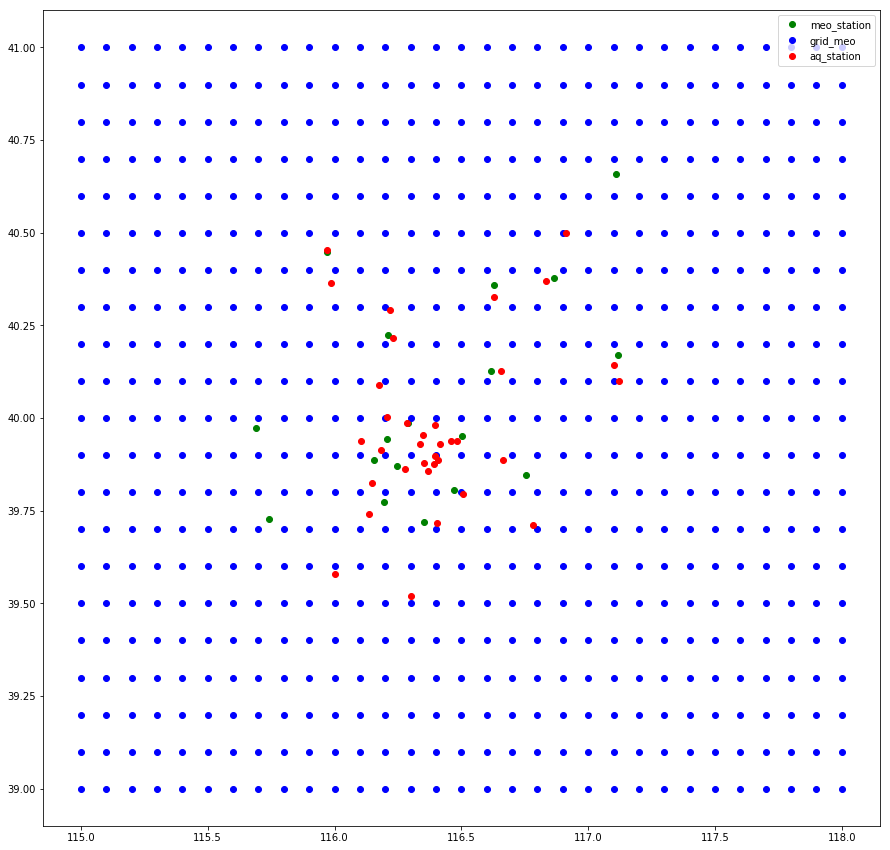

In [11]:
plt.rc("figure", figsize=(15,15));
plt.plot(meo_locations_longitudes, meo_locations_latitudes, "go", label="meo_station");
plt.plot(grid_meo_locations_longitudes, grid_meo_locations_latitudes, "bo", label="grid_meo");
plt.plot(aq_locations_longitudes, aq_locations_latitudes, "ro", label="aq_station");
plt.legend();

- 由于点非常密集，暂时不使用插值的方式，而是直接选用和 aq_station 最近的 meo_station 的天气值作为 aq_station 的天气值
- 同时，由于`观测气象数据`采集的时间短于空气质量数据，因此只使用`网格气象数据`
- 注意，与`观测气象数据`相比，`网格气象数据`没有`weather`属性

In [12]:
aq_station_nearest_meo_station = {}

# 暂时只使用 网格气象数据
# stations = meo_locations + grid_meo_locations
stations = grid_meo_locations

for aq_station in aq_locations:
    nearest_meo_station_name = find_nearst_meo_station_name(aq_station, stations)
    aq_station_nearest_meo_station[aq_station[0]] = nearest_meo_station_name

In [13]:
# 空气质量站点 与 天气站点
aq_station_nearest_meo_station

{'aotizhongxin_aq': 'beijing_grid_304',
 'badaling_aq': 'beijing_grid_224',
 'beibuxinqu_aq': 'beijing_grid_263',
 'daxing_aq': 'beijing_grid_301',
 'dingling_aq': 'beijing_grid_265',
 'donggaocun_aq': 'beijing_grid_452',
 'dongsi_aq': 'beijing_grid_303',
 'dongsihuan_aq': 'beijing_grid_324',
 'fangshan_aq': 'beijing_grid_238',
 'fengtaihuayuan_aq': 'beijing_grid_282',
 'guanyuan_aq': 'beijing_grid_282',
 'gucheng_aq': 'beijing_grid_261',
 'huairou_aq': 'beijing_grid_349',
 'liulihe_aq': 'beijing_grid_216',
 'mentougou_aq': 'beijing_grid_240',
 'miyun_aq': 'beijing_grid_392',
 'miyunshuiku_aq': 'beijing_grid_414',
 'nansanhuan_aq': 'beijing_grid_303',
 'nongzhanguan_aq': 'beijing_grid_324',
 'pingchang_aq': 'beijing_grid_264',
 'pinggu_aq': 'beijing_grid_452',
 'qianmen_aq': 'beijing_grid_303',
 'shunyi_aq': 'beijing_grid_368',
 'tiantan_aq': 'beijing_grid_303',
 'tongzhou_aq': 'beijing_grid_366',
 'wanliu_aq': 'beijing_grid_283',
 'wanshouxigong_aq': 'beijing_grid_303',
 'xizhimenbei_

对于上述字典中的键对应的 aq_station，直接使用对应的 value 作为其天气数据

### 3. 将天气dataframe添加到空气质量dataframe

In [39]:
# related_meo_dfs : dict with aq_station_name as key and meo df as value
related_meo_dfs = get_related_meo_dfs(aq_station_nearest_meo_station, bj_meo_all, bj_grid_meo_all)

In [44]:
# 对每一个表做一些处理，删掉没用的列，并对列名进行修改
for key, df in related_meo_dfs.items():
    
    drop_list = ["stationName", "longitude", "latitude"]
    for item in drop_list:
        if item in df.columns:
            df.drop(item, axis=1, inplace=True)
    
    # 将 string 类型的日期转换为 datetime 类型
    df['format_time'] = pd.to_datetime(df['utc_time'], format='%Y-%m-%d %H:%M:%S')
    df.set_index("format_time", inplace=True)
    df.drop("utc_time", axis=1, inplace=True)
    
    original_names = df.columns.values.tolist()
    names_dict = {original_name : key.split("_")[0] +"_"+original_name for original_name in original_names}
    df.rename(index=str, columns=names_dict, inplace=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/pyt

In [161]:
# 融合成一个整表
meo_merged = pd.concat(list(related_meo_dfs.values()), axis=1)

In [162]:
print(meo_merged.shape)
meo_merged.head()

(10806, 175)


,shunyi_temperature,shunyi_pressure,shunyi_humidity,shunyi_wind_direction,shunyi_wind_speed/kph,wanliu_temperature,wanliu_pressure,wanliu_humidity,wanliu_wind_direction,wanliu_wind_speed/kph,...,guanyuan_temperature,guanyuan_pressure,guanyuan_humidity,guanyuan_wind_direction,guanyuan_wind_speed/kph,yongledian_temperature,yongledian_pressure,yongledian_humidity,yongledian_wind_direction,yongledian_wind_speed/kph
format_time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-7.27,1023.39,77.77,187.44,2.76,-5.85,1015.90,68.60,127.99,3.54,...,-5.60,1018.74,70.31,117.25,4.01,-6.31,1024.83,84.56,332.72,0.86
2017-01-01 01:00:00,-4.29,1023.24,64.29,203.94,3.11,-3.11,1015.78,58.00,136.80,3.32,...,-3.04,1018.64,59.58,123.40,3.69,-3.84,1024.73,71.76,304.70,1.62
2017-01-01 02:00:00,-1.31,1023.08,50.80,216.29,3.67,-0.37,1015.65,47.40,146.58,3.19,...,-0.48,1018.53,48.86,130.62,3.42,-1.37,1024.62,58.96,295.43,2.51
2017-01-01 03:00:00,1.68,1022.92,37.32,225.13,4.34,2.37,1015.52,36.80,156.85,3.16,...,2.08,1018.42,38.13,138.92,3.22,1.10,1024.51,46.16,291.08,3.43
2017-01-01 04:00:00,2.73,1022.26,35.32,215.03,4.36,3.50,1014.84,34.36,148.91,4.01,...,3.21,1017.74,35.57,139.44,3.96,2.17,1023.83,43.39,285.96,2.99


## 将天气表和空气质量表的时间调整成统一的

- 网格气象数据
    - 2017:01:01 0:00 - 2018:03:27 5:00 
- 空气质量数据
    - 2017:01:01 14:00 - 2018:03:31 15:00
- 考虑选择整天的数据
    - 选择2017:01:02 00:00 - 2018:03:26 23:00

In [164]:
t1 = datetime.datetime(2017,1,2,0,0,0)
t2 = datetime.datetime(2018,3,26,23,0,0)
dd = t2 - t1
print("There should be %d hours" %((dd.total_seconds() / 3600) + 1))

There should be 10776 hours


In [151]:
_, _, _, aq_merged = parse_bj_aq_data()

NaN in PM2.5 is 23459, 6.508615 %
NaN in PM10 is 96175, 26.683406 %
NaN in NO2 is 21720, 6.026135 %
NaN in CO is 46144, 12.802486 %
NaN in O3 is 23732, 6.584358 %
NaN in SO2 is 21664, 6.010598 %
There are 35 air quality stations in Beijing

The stations in Beijing are:
 {'yufa_aq', 'miyun_aq', 'fengtaihuayuan_aq', 'donggaocun_aq', 'yungang_aq', 'liulihe_aq', 'badaling_aq', 'yanqin_aq', 'daxing_aq', 'beibuxinqu_aq', 'tongzhou_aq', 'wanshouxigong_aq', 'nongzhanguan_aq', 'tiantan_aq', 'mentougou_aq', 'shunyi_aq', 'wanliu_aq', 'nansanhuan_aq', 'fangshan_aq', 'yizhuang_aq', 'aotizhongxin_aq', 'dingling_aq', 'gucheng_aq', 'guanyuan_aq', 'xizhimenbei_aq', 'pinggu_aq', 'qianmen_aq', 'dongsi_aq', 'miyunshuiku_aq', 'huairou_aq', 'pingchang_aq', 'zhiwuyuan_aq', 'yongdingmennei_aq', 'dongsihuan_aq', 'yongledian_aq'}


/notebooks/KDD_Cup_2018/utils/data_util.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bj_aq_station.drop("utc_time", axis=1, inplace=True)
/notebooks/KDD_Cup_2018/utils/data_util.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bj_aq_station.drop("stationId", axis=1, inplace=True)


In [152]:
aq_merged = aq_merged[aq_merged.index < '2018-03-27 00:00:00']
aq_merged = aq_merged[aq_merged.index > '2017-01-01 23:00:00']
print(aq_merged.shape)

(10176, 210)


In [165]:
meo_merged = meo_merged[meo_merged.index < '2018-03-27 00:00:00']
meo_merged = meo_merged[meo_merged.index > '2017-01-01 23:00:00']
meo_merged.shape

(10776, 175)

由上可知，meo_merged 完全没有空缺，但是 aq_merged 有一定程度的日期缺失

统计一些缺少哪些

In [171]:
print(aq_merged.shape, meo_merged.shape)

(10176, 210) (10776, 175)


In [172]:
empty = []
for index in meo_merged.index:
    if index not in aq_merged.index : 
        # print(index)
        empty.append(index)

In [175]:
len(empty), len(meo_merged.index)

(785, 10776)

In [177]:
# 这里为什么 长度 和 上述长度差值 不统一？？？？？？
l = [i[:10] for i in empty]

In [186]:
from collections import Counter
c = Counter(l)

In [194]:
c

Counter({'2017-01-23': 2,
         '2017-01-24': 7,
         '2017-01-25': 10,
         '2017-01-26': 14,
         '2017-01-27': 2,
         '2017-02-05': 1,
         '2017-02-06': 5,
         '2017-02-07': 3,
         '2017-02-08': 11,
         '2017-02-09': 4,
         '2017-02-19': 4,
         '2017-02-20': 7,
         '2017-02-21': 3,
         '2017-03-07': 2,
         '2017-03-08': 1,
         '2017-03-09': 12,
         '2017-03-10': 11,
         '2017-03-11': 18,
         '2017-03-12': 16,
         '2017-03-13': 20,
         '2017-03-14': 16,
         '2017-03-15': 8,
         '2017-03-16': 6,
         '2017-03-28': 6,
         '2017-03-29': 1,
         '2017-04-19': 5,
         '2017-04-20': 12,
         '2017-04-21': 13,
         '2017-04-22': 10,
         '2017-04-23': 21,
         '2017-04-24': 1,
         '2017-05-13': 1,
         '2017-05-18': 15,
         '2017-05-19': 24,
         '2017-05-20': 24,
         '2017-05-21': 24,
         '2017-05-22': 24,
         '2017-05-23

In [192]:
num = Counter(c.values())

<Container object of 19 artists>

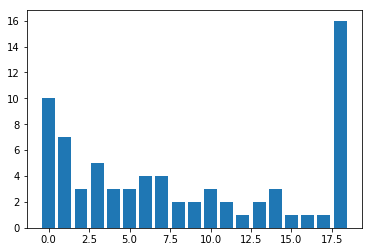

In [193]:
# 柱状图
plt.bar(range(len(num.values())), num.values())

In [96]:
# all_merged = pd.concat([aq_merged, meo_merged], axis=1)